## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [9]:
import os
import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2

"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [10]:
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/500

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 163us/step - loss: 198.7438 - accuracy: 0.2393 - val_loss: 41.1828 - val_accuracy: 0.2375
Epoch 2/10
50000/50000 [==============================] - 7s 142us/step - loss: 19.1593 - accuracy: 0.1169 - val_loss: 7.3298 - val_accuracy: 0.1000
Epoch 3/10
50000/50000 [==============================] - 6s 130us/step - loss: 4.1387 - accuracy: 0.0989 - val_loss: 2.6581 - val_accuracy: 0.1000
Epoch 4/10
50000/50000 [==============================] - 6s 130us/step - loss: 2.4880 - accuracy: 0.0979 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 5/10
50000/50000 [==============================] - 6s 129us/step - loss: 2.4626 - accuracy: 0.0975 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 6/10
50000/50000 [==============================] - 6s 128us/step - loss: 2.4626 - accuracy: 0.0991 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 7/10
50000/50000 [==============================] - 

50000/50000 [==============================] - 6s 130us/step - loss: 5.6991 - accuracy: 0.3936 - val_loss: 5.6338 - val_accuracy: 0.4096
Epoch 4/10
50000/50000 [==============================] - 6s 129us/step - loss: 5.5766 - accuracy: 0.4147 - val_loss: 5.5368 - val_accuracy: 0.4124
Epoch 5/10
50000/50000 [==============================] - 6s 129us/step - loss: 5.4637 - accuracy: 0.4316 - val_loss: 5.4146 - val_accuracy: 0.4369
Epoch 6/10
50000/50000 [==============================] - 6s 129us/step - loss: 5.3588 - accuracy: 0.4423 - val_loss: 5.3223 - val_accuracy: 0.4410
Epoch 7/10
50000/50000 [==============================] - 6s 130us/step - loss: 5.2593 - accuracy: 0.4541 - val_loss: 5.2276 - val_accuracy: 0.4495
Epoch 8/10
50000/50000 [==============================] - 6s 129us/step - loss: 5.1616 - accuracy: 0.4639 - val_loss: 5.1375 - val_accuracy: 0.4580
Epoch 9/10
50000/50000 [==============================] - 6s 129us/step - loss: 5.0688 - accuracy: 0.4748 - val_loss: 5.059

Epoch 6/10
50000/50000 [==============================] - 6s 116us/step - loss: 5.2414 - accuracy: 0.4420 - val_loss: 5.2094 - val_accuracy: 0.4404
Epoch 7/10
50000/50000 [==============================] - 6s 113us/step - loss: 5.1468 - accuracy: 0.4537 - val_loss: 5.1182 - val_accuracy: 0.4523
Epoch 8/10
50000/50000 [==============================] - 6s 113us/step - loss: 5.0585 - accuracy: 0.4640 - val_loss: 5.0286 - val_accuracy: 0.4573
Epoch 9/10
50000/50000 [==============================] - 6s 116us/step - loss: 4.9682 - accuracy: 0.4733 - val_loss: 4.9577 - val_accuracy: 0.4642
Epoch 10/10
50000/50000 [==============================] - 6s 113us/step - loss: 4.8835 - accuracy: 0.4817 - val_loss: 4.9170 - val_accuracy: 0.4543
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         

Epoch 9/10
50000/50000 [==============================] - 6s 125us/step - loss: 1.4940 - accuracy: 0.4760 - val_loss: 1.5163 - val_accuracy: 0.4630
Epoch 10/10
50000/50000 [==============================] - 6s 125us/step - loss: 1.4716 - accuracy: 0.4842 - val_loss: 1.4962 - val_accuracy: 0.4651
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_______________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 127us/step - loss: 2.1645 - accuracy: 0.2755 - val_loss: 1.9997 - val_accuracy: 0.3490
Epoch 2/10
50000/50000 [==============================] - 6s 123us/step - loss: 1.9417 - accuracy: 0.3637 - val_loss: 1.8934 - val_accuracy: 0.3770
Epoch 3/10
50000/50000 [==============================] - 6s 123us/step - loss: 1.8561 - accuracy: 0.3958 - val_loss: 1.8293 - val_accuracy: 0.4105
Epoch 4/10
50000/50000 [==============================] - 6s 123us/step - loss: 1.7962 - accuracy: 0.4172 - val_loss: 1.7761 - val_accuracy: 0.4281
Epoch 5/10
50000/50000 [==============================] - 6s 123us/step - loss: 1.7493 - accuracy: 0.4354 - val_loss: 1.7447 - val_accuracy: 0.4408
Epoch 6/10
50000/50000 [==============================] - 6s 124us/step - loss: 1.7105 - accuracy: 0.4512 - val_loss: 1.7119 - val_accuracy: 0.4460
Epoch 7/10
50000/50000 [==============================] - 6s 1

50000/50000 [==============================] - 6s 112us/step - loss: 1.7243 - accuracy: 0.3980 - val_loss: 1.7052 - val_accuracy: 0.4026
Epoch 4/10
50000/50000 [==============================] - 6s 112us/step - loss: 1.6650 - accuracy: 0.4186 - val_loss: 1.6451 - val_accuracy: 0.4233
Epoch 5/10
50000/50000 [==============================] - 6s 113us/step - loss: 1.6192 - accuracy: 0.4336 - val_loss: 1.6027 - val_accuracy: 0.4323
Epoch 6/10
50000/50000 [==============================] - 6s 114us/step - loss: 1.5787 - accuracy: 0.4476 - val_loss: 1.5813 - val_accuracy: 0.4455
Epoch 7/10
50000/50000 [==============================] - 6s 112us/step - loss: 1.5455 - accuracy: 0.4596 - val_loss: 1.5453 - val_accuracy: 0.4554
Epoch 8/10
50000/50000 [==============================] - 6s 113us/step - loss: 1.5129 - accuracy: 0.4707 - val_loss: 1.5170 - val_accuracy: 0.4650
Epoch 9/10
50000/50000 [==============================] - 6s 113us/step - loss: 1.4847 - accuracy: 0.4790 - val_loss: 1.507

Epoch 6/10
50000/50000 [==============================] - 5s 109us/step - loss: 1.5789 - accuracy: 0.4489 - val_loss: 1.5697 - val_accuracy: 0.4451
Epoch 7/10
50000/50000 [==============================] - 5s 109us/step - loss: 1.5438 - accuracy: 0.4616 - val_loss: 1.5441 - val_accuracy: 0.4563
Epoch 8/10
50000/50000 [==============================] - 5s 110us/step - loss: 1.5118 - accuracy: 0.4709 - val_loss: 1.5456 - val_accuracy: 0.4533
Epoch 9/10
50000/50000 [==============================] - 5s 109us/step - loss: 1.4849 - accuracy: 0.4823 - val_loss: 1.5020 - val_accuracy: 0.4675
Epoch 10/10
50000/50000 [==============================] - 6s 110us/step - loss: 1.4584 - accuracy: 0.4885 - val_loss: 1.4907 - val_accuracy: 0.4674
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         

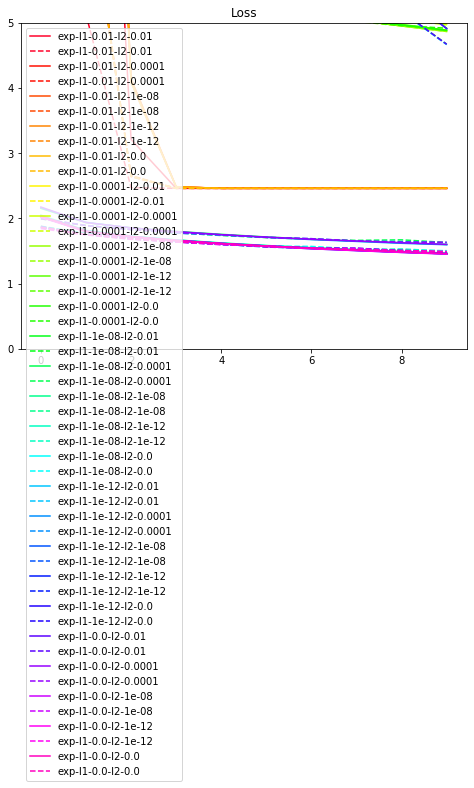

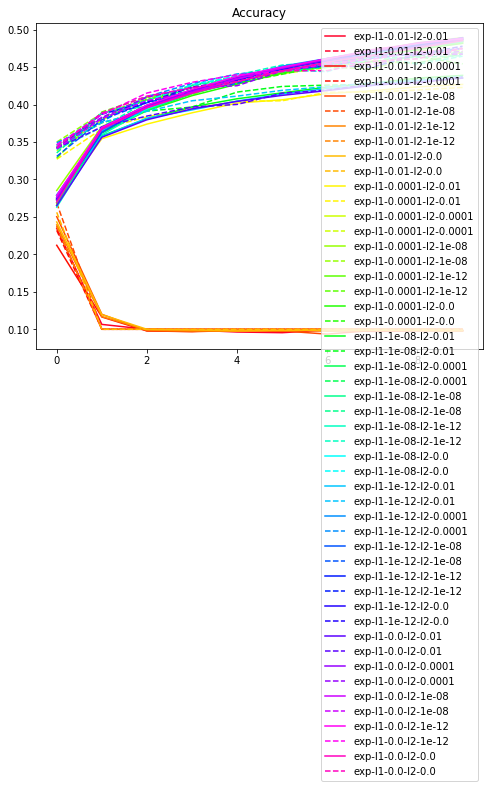

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()